<a href="https://colab.research.google.com/github/julycapstone2020/Pneumonia-Detection-Challenge/blob/development/PneumoniaDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install pydicom

     |████████████████████████████████| 35.5MB 99kB/s 


In [4]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
from google.colab import drive
%matplotlib inline 
IS_LOCAL = False
import os


In [5]:
drive.mount('/content/my-drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/my-drive


In [19]:
!ls '/content/my-drive/My Drive'

'Colab Notebooks'       stage_2_detailed_class_info.csv
'https:  goo.gl .txt'   stage_2_train_labels.csv


In [21]:
class_info_df = pd.read_csv('/content/my-drive/My Drive/stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv('/content/my-drive/My Drive/stage_2_train_labels.csv')      

In [22]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


In [23]:
class_info_df.sample(10)

,patientId,class
12907,82a2e069-1e54-45f5-9c96-49cd1d31f661,Normal
24584,dce40126-49cb-444e-99fc-a5d5546569de,No Lung Opacity / Not Normal
20029,b88918d9-41ef-4a44-b7f6-0540b84e1038,No Lung Opacity / Not Normal
18617,af1d13fe-4442-418a-ab7d-01983275a99a,Lung Opacity
12968,83272c3d-51d2-4c0e-9964-fafb76753126,No Lung Opacity / Not Normal
22818,cdd3a281-fd3e-40a4-9276-3cce68ec47a8,No Lung Opacity / Not Normal
19416,b460b35c-214c-45b6-8306-3bf234116ca9,Lung Opacity
12700,80ef2532-7497-4e5e-bdcc-d97da06da0b5,Lung Opacity
7272,55a477a0-5a3d-4b7c-b498-b81f92368efe,No Lung Opacity / Not Normal
8717,61c03c4d-63d4-4f53-9f22-0c52e037ddfd,No Lung Opacity / Not Normal


In [24]:
train_labels_df.sample(10)

,patientId,x,y,width,height,Target
29956,2b4c09a2-c8d7-4773-84e3-f1aa664fba9a,604.0,214.0,267.0,387.0,1
18406,adbd0f93-b694-41f2-947e-44c7804cacb4,191.0,262.0,222.0,410.0,1
9849,6aa4fb59-0bea-40b9-9c66-83199d91714e,184.0,375.0,193.0,166.0,1
4220,3d643bc7-85ea-4684-88f6-4e2ee36ff46d,585.0,366.0,238.0,518.0,1
1718,1833d175-c9c8-40f3-9687-2a253e447579,NaN,NaN,NaN,NaN,0
13778,89d67820-5212-4657-b891-0859868d0097,NaN,NaN,NaN,NaN,0
14525,8f66472e-29c1-4dc5-86d7-8e0fa67e9f74,NaN,NaN,NaN,NaN,0
14523,8f615e7a-eedb-4f8b-b6da-4b36dab3ed46,NaN,NaN,NaN,NaN,0
3119,364b4a5e-baf6-40a8-ab77-a68b3aaec56f,NaN,NaN,NaN,NaN,0
14903,928aaa10-715f-4b4f-a1df-16f16310b20e,NaN,NaN,NaN,NaN,0


In [25]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))

missing_data(train_labels_df)

,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


In [26]:
missing_data(class_info_df)

,class,patientId
Total,0.0,0.0
Percent,0.0,0.0


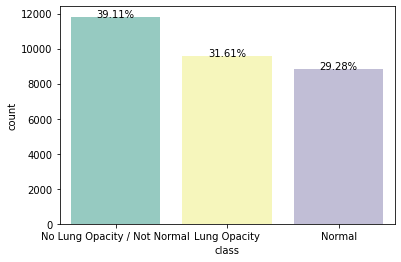

In [27]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [28]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [29]:
train_class_df.sample(5)

,patientId,x,y,width,height,Target,class
28050,c7c814c0-aca7-449c-a286-83fb143a6c3b,NaN,NaN,NaN,NaN,0,Normal
26258,bcda188a-9594-4ce0-8802-dfc2640dce25,NaN,NaN,NaN,NaN,0,Normal
8410,4d43c0dd-d87b-4ccf-83df-c82be5ea2aef,175.0,393.0,168.0,348.0,1,Lung Opacity
18933,948a5b14-8b18-4709-9405-c7c0b3e7e0c3,NaN,NaN,NaN,NaN,0,Normal
29363,d1027667-a69d-42be-bf68-55cd04739347,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [30]:
# All chest examinations withTarget = 1 (pathology detected) associated with class: Lung Opacity.
# The chest examinations with Target = 0 (no pathology detected) are either of class: Normal or class: No Lung Opacity / Not Normal.

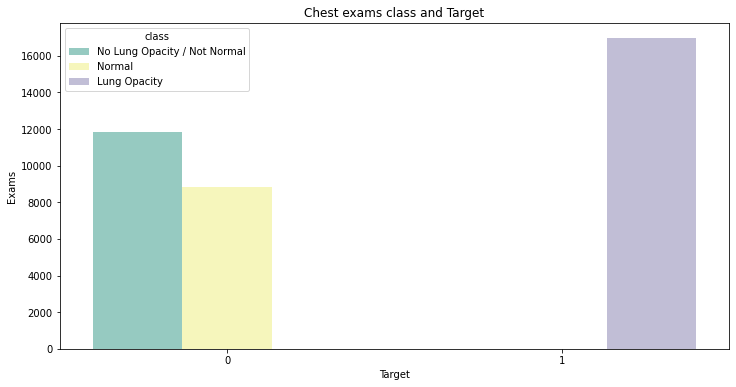

In [31]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

In [32]:
## Explore DICOM data

<Figure size 432x288 with 0 Axes>

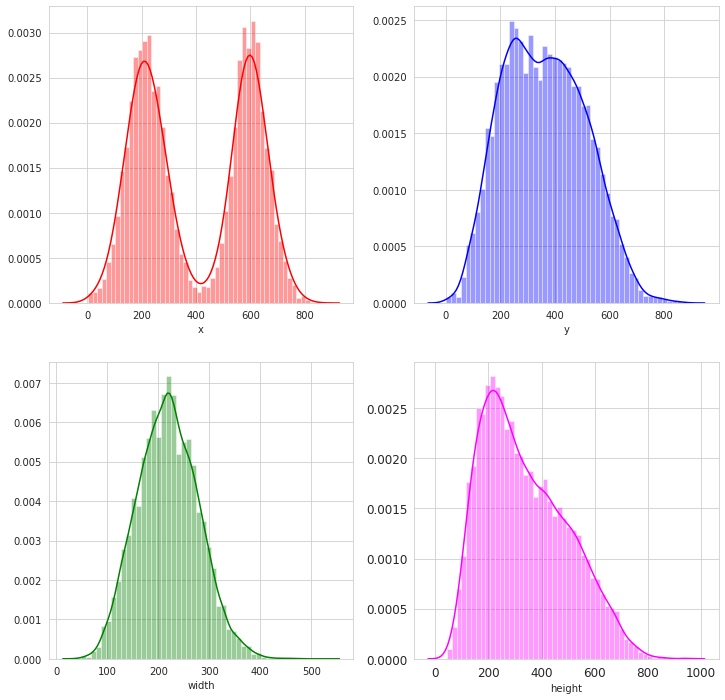

In [33]:
target1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

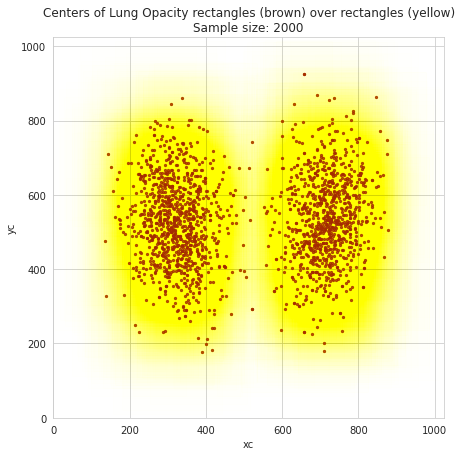

In [34]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

In [37]:
!ls '/content/my-drive/My Drive'

'Colab Notebooks'			  stage_2_detailed_class_info.csv
'https:  goo.gl .txt'			  stage_2_train_labels.csv
 rsna-pneumonia-detection-challenge.zip
